# 📰 **Abstractive Text Summarization with Transformers**
---

Text summarization is a critical task in **Natural Language Processing (NLP)** that focuses on condensing long documents into shorter, coherent summaries while preserving the original meaning.  
This project implements **abstractive summarization**, where the model generates novel sentences instead of directly extracting portions of the text.  

---

# 🔑 **Key Highlights**
- **Dataset**: CNN/DailyMail news articles and their human-written summaries.  
- **Approach**: Fine-tuning **BART (facebook/bart-large-cnn)**, a state-of-the-art Transformer model, for abstractive summarization.  
- **Evaluation**: Using the **ROUGE metric(* to assess summary quality.  
- **Data Analysis**: Exploratory visualizations of article lengths, summary distributions, and comparison plots.  
- **Deployment**: Inference pipeline to generate high-quality summaries for unseen news articles.  
----
# 🎯 **Objective**
The primary goal of this project is to demonstrate how Transformer-based models can **understand context, capture semantics, and generate human-like summaries** that are both concise and informative.  
Beyond technical implementation, this project highlights the importance of **automated summarization systems** in real-world applications such as news aggregation, digital assistants, and academic research tools, where rapid and accurate information extraction is essential.

# **Setup & Installation**

In [1]:
!pip install transformers datasets rouge_score -q
!pip install evaluate -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nv

# **Imports**

In [2]:
import re
import torch
import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from datasets import load_dataset

2025-10-03 10:00:36.973710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759485637.165705      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759485637.218416      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Load Dataset (Example: CNN/DailyMail)**

In [3]:
dataset = load_dataset("cnn_dailymail", "3.0.0")
print(dataset)

README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


# **Load Pretrained Model**

In [4]:
model_name = "facebook/bart-large-cnn"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

# **Exploratory Data Analysis (EDA)**

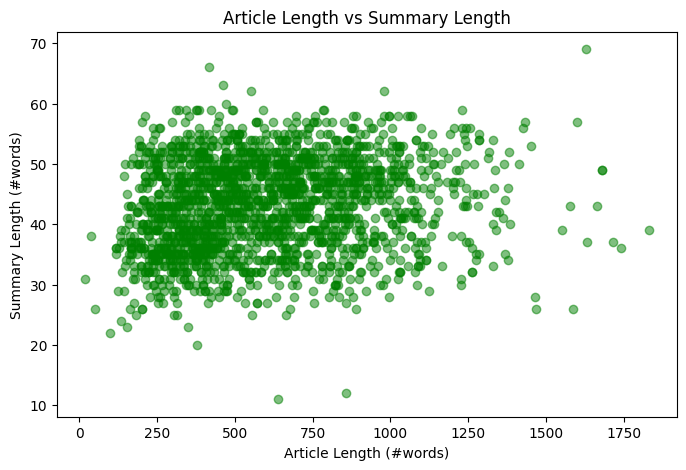

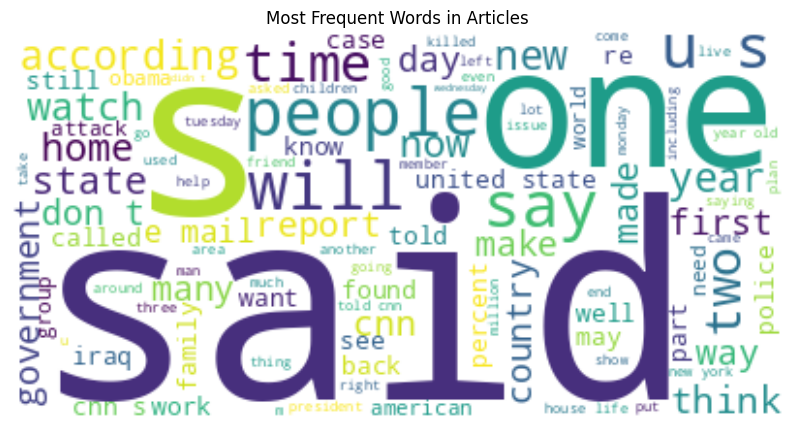

In [5]:

dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:2000]")
df = pd.DataFrame(dataset)

df["article_length"] = df["article"].apply(lambda x: len(x.split()))
df["summary_length"] = df["highlights"].apply(lambda x: len(x.split()))


plt.figure(figsize=(8,5))
plt.scatter(df["article_length"], df["summary_length"], alpha=0.5, color="green")
plt.title("Article Length vs Summary Length")
plt.xlabel("Article Length (#words)")
plt.ylabel("Summary Length (#words)")
plt.show()

all_text = " ".join(df["article"])
all_text = re.sub(r"[^a-zA-Z ]", " ", all_text.lower())

wc = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=100).generate(all_text)

plt.figure(figsize=(10,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Articles")
plt.show()

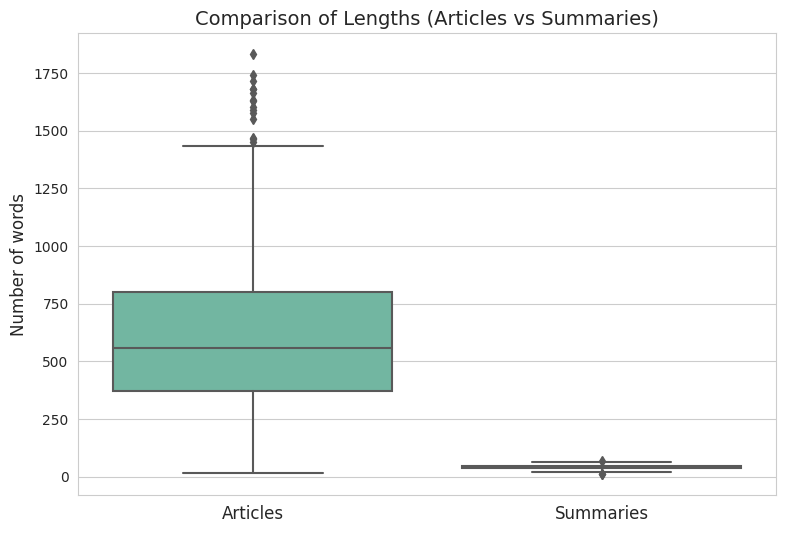

In [6]:

dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:2000]")
df = pd.DataFrame(dataset)

df["article_length"] = df["article"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df["summary_length"] = df["highlights"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

article_lengths = df["article_length"].values
summary_lengths = df["summary_length"].values

sns.set_style("whitegrid")
plt.figure(figsize=(9,6))
sns.boxplot(data=[article_lengths, summary_lengths], palette="Set2")
plt.xticks([0,1], ["Articles", "Summaries"], fontsize=12)
plt.ylabel("Number of words", fontsize=12)
plt.title("Comparison of Lengths (Articles vs Summaries)", fontsize=14)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


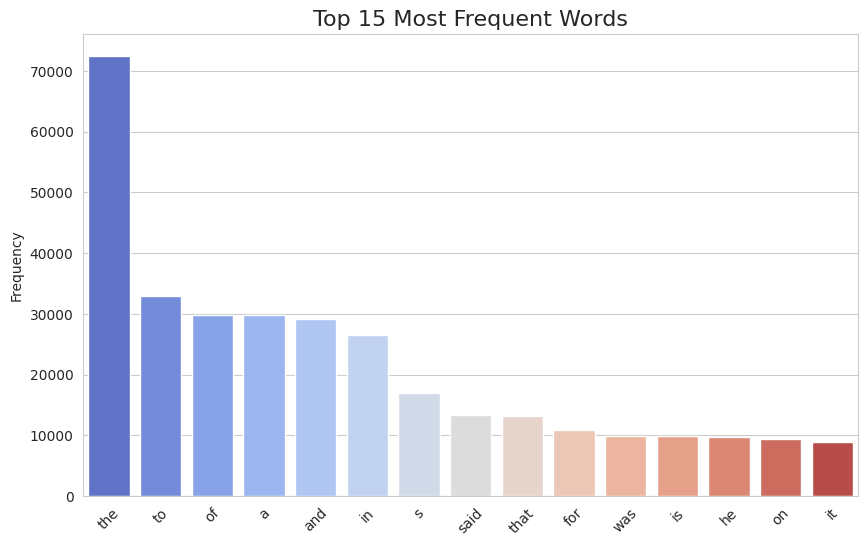

In [7]:

words = all_text.split()
word_freq = Counter(words)
common_words = word_freq.most_common(15)

words, counts = zip(*common_words)

plt.figure(figsize=(10,6))
sns.barplot(x=list(words), y=list(counts), palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 15 Most Frequent Words", fontsize=16)
plt.ylabel("Frequency")
plt.show()

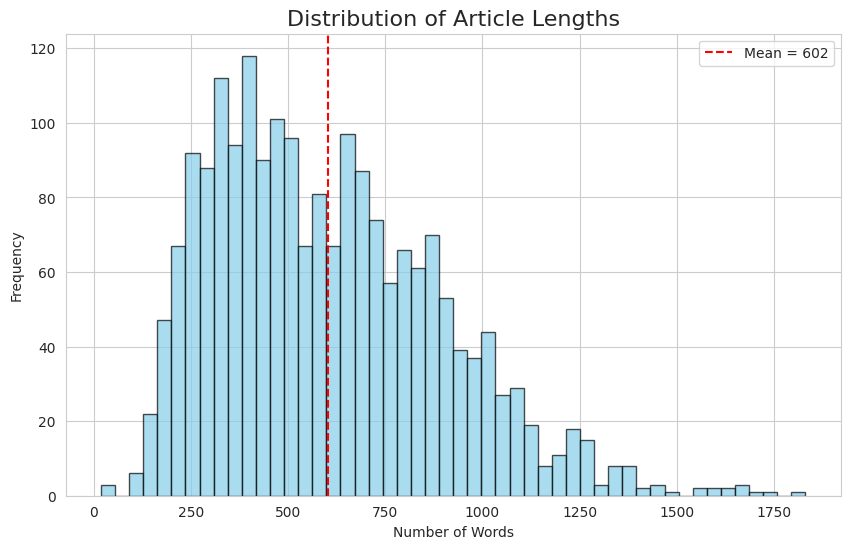

In [8]:
plt.figure(figsize=(10,6))
plt.hist(article_lengths, bins=50, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(np.mean(article_lengths), color='red', linestyle='--', label=f"Mean = {np.mean(article_lengths):.0f}")
plt.title("Distribution of Article Lengths", fontsize=16)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# **Preprocessing Function**

In [9]:
def preprocess_data(batch):
    inputs = tokenizer(batch['article'], max_length=512, truncation=True, padding="max_length", return_tensors="pt")
    outputs = tokenizer(batch['highlights'], max_length=128, truncation=True, padding="max_length", return_tensors="pt")
    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["labels"] = outputs.input_ids
    return batch

# **Quick Test Inference**

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

text = dataset[0]["article"]

inputs = tokenizer([text], max_length=1024, truncation=True, return_tensors="pt").to(device)

summary_ids = model.generate(
    inputs["input_ids"], 
    num_beams=4, 
    min_length=30, 
    max_length=200, 
    early_stopping=True
)

print("Generated Summary:\n", tokenizer.decode(summary_ids[0], skip_special_tokens=True))
print("\nReference Summary:\n", dataset[0]["highlights"])

Generated Summary:
 Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund.

Reference Summary:
 Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


# **Evaluation with ROUGE**

In [11]:

rouge = evaluate.load("rouge")

def evaluate_model(dataset, num_samples=50, batch_size=8, show_examples=3):
    refs, preds = [], []

    if isinstance(dataset, dict) and "test" in dataset:
        dataset_split = dataset["test"]
    else:
        dataset_split = dataset

    for i in range(0, min(num_samples, len(dataset_split)), batch_size):
        batch = [dataset_split[j] for j in range(i, min(i+batch_size, num_samples))]
        articles = [sample["article"] for sample in batch]
        references = [sample["highlights"] for sample in batch]
        
        inputs = tokenizer(
            articles, 
            max_length=512,   
            truncation=True, 
            padding=True,
            return_tensors="pt"
        ).to(device)
        
        summary_ids = model.generate(
            inputs["input_ids"], 
            num_beams=1, 
            max_length=200, 
            early_stopping=True
        )
        
        predictions = [tokenizer.decode(g, skip_special_tokens=True) for g in summary_ids]
        
        preds.extend(predictions)
        refs.extend(references)
    
    results = rouge.compute(predictions=preds, references=refs)

    print(" ROUGE Scores:")
    for key, value in results.items():
        print(f"{key}: {value:.4f}")
    
    print("\n--- Example Summaries ---")
    for i in range(min(show_examples, len(preds))):
        print(f"\nReference {i+1}:")
        print(refs[i])
        print(f"\nPrediction {i+1}:")
        print(preds[i])
        print("-"*60)
    
    return results


results = evaluate_model(dataset, num_samples=50, batch_size=8, show_examples=3)

The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['ear

 ROUGE Scores:
rouge1: 0.3620
rouge2: 0.1536
rougeL: 0.2618
rougeLsum: 0.3065

--- Example Summaries ---

Reference 1:
Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .

Prediction 1:
Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million fortune as he turns 18. Radcliffe says he has no plans to fritter his cash away on fast cars, drink. He will be able to gamble in a casino, buy a drink in a pub or see "Hostel: Part II"
------------------------------------------------------------

Reference 2:
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

Predict

# 📰 **Abstractive Summarization of Multiple News Articles with BART**

In [12]:

model_name = "facebook/bart-large-cnn"   
summarizer = pipeline("summarization", model=model_name, tokenizer=model_name, device=0)

texts = [
    # Article 1
    """The European Central Bank (ECB) on Thursday raised interest rates for the tenth consecutive time, 
    pressing ahead with its fight against stubborn inflation even as the eurozone economy falters. 
    The ECB increased its main deposit rate by a quarter of a percentage point to 4%, the highest level 
    since the euro was launched in 1999. Inflation across the 20 countries that use the euro currency 
    has been easing, falling to 5.3% in August from a peak above 10% last year. But it remains well above 
    the ECB’s 2% target. The ECB also cut its forecasts for economic growth in the eurozone, predicting the bloc 
    will expand just 0.7% this year and 1% in 2024. That compares with previous forecasts of 0.9% and 1.5%. 
    Higher interest rates make borrowing more expensive for households and companies, which can weigh on spending 
    and investment. But they also help reduce inflation by slowing demand.""",

    # Article 2
    """NASA’s Perseverance rover has collected its 20th sample from the surface of Mars, marking another 
    milestone in the mission to bring pieces of the Red Planet back to Earth. The rover, which landed in 
    Jezero Crater in February 2021, has been exploring ancient river deltas and searching for signs of past 
    microbial life. Scientists believe the rocks in this area are billions of years old and may contain evidence 
    of water that once flowed on Mars. The samples will eventually be returned to Earth by a future mission, 
    allowing scientists to study them in laboratories with much greater precision than is possible on Mars. 
    The collection is part of NASA’s ambitious Mars Sample Return program, which involves multiple spacecraft 
    and international cooperation. If successful, it would be the first time humanity has retrieved materials 
    from another planet.""",

    # Article 3
    """Apple unveiled its new iPhone lineup at a live event in Cupertino, California, highlighting upgraded 
    cameras, faster processors, and new AI-powered features. The flagship iPhone 15 Pro includes a titanium 
    frame, making it both lighter and stronger, and introduces a periscope-style telephoto lens capable of 
    5x optical zoom. Apple also announced that all new iPhones will transition to USB-C charging ports, 
    complying with new European regulations. The company emphasized its commitment to sustainability, 
    noting that the new models use recycled materials and reduce carbon emissions in production. 
    Analysts expect strong sales, especially during the holiday season, but competition from Samsung and 
    Chinese manufacturers remains fierce.""",

    # Article 4
    """Climate scientists have warned that the summer of 2023 was the hottest ever recorded, with global 
    temperatures shattering previous records. Prolonged heatwaves struck North America, Europe, and Asia, 
    leading to widespread droughts, wildfires, and health emergencies. The United Nations called the trend 
    a "code red" for humanity, urging governments to accelerate efforts to cut greenhouse gas emissions. 
    Experts say the record-breaking heat is consistent with predictions about climate change caused by 
    burning fossil fuels. They stress the urgency of transitioning to renewable energy sources and 
    implementing policies to reduce carbon footprints. Despite the warnings, progress on international 
    climate agreements has been slow.""",

    # Article 5
    """Artificial intelligence is rapidly transforming the healthcare industry, from diagnosing diseases 
    to personalizing treatment plans. Researchers have developed AI algorithms that can detect cancer from 
    medical images with accuracy levels comparable to human doctors. Hospitals are increasingly adopting AI 
    tools to predict patient deterioration, optimize staffing, and manage resources more efficiently. 
    However, concerns remain about data privacy, algorithmic bias, and the need for transparency in 
    decision-making. Experts believe that while AI will not replace doctors, it will become an indispensable 
    tool in modern medicine, helping clinicians provide better and faster care to patients.""",
]

summaries = summarizer(texts, max_length=200, min_length=60, do_sample=False)

for i, s in enumerate(summaries):
    print(f"\n--- Summary {i+1} ---")
    print(s['summary_text'])

Device set to use cuda:0
Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)
Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)
Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)



--- Summary 1 ---
The ECB increased its main deposit rate by a quarter of a percentage point to 4%. Inflation across the 20 countries that use the euro currency has been easing. The ECB also cut its forecasts for economic growth in the eurozone. It predicts the bloc  will expand just 0.7% this year and 1% in 2024.

--- Summary 2 ---
NASA’s Perseverance rover has collected its 20th sample from the surface of Mars. The rover has been exploring ancient river deltas and searching for signs of past microbial life. The samples will eventually be returned to Earth by a future mission. If successful, it would be the first time humanity has retrieved materials from another planet.

--- Summary 3 ---
Apple unveiled its new iPhone lineup at a live event in Cupertino, California. The flagship iPhone 15 Pro includes a titanium  frame, making it both lighter and stronger. Apple also announced that all new iPhones will transition to USB-C charging ports. The company emphasized its commitment to sust